# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from matplotlib import pyplot as plt
from wordcloud import WordCloud 
import string
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
#Some punctuation variations
punctuation = set(string.punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print the number of tokens, number of unique tokens,
    number of characters, lexical diversity, and num_tokens most common tokens.
    Return a list of the num_tokens most common tokens.
    """
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    num_characters = sum(len(token) for token in tokens)
    lexical_diversity = num_unique_tokens / num_tokens

    if verbose:
        print("Number of tokens:", num_tokens)
        print("Number of unique tokens:", num_unique_tokens)
        print("Number of characters:", num_characters)
        print("Lexical diversity:", lexical_diversity)
        # Print the 5 most common tokens
        common_tokens = Counter(tokens).most_common(num_tokens)
        print("The most common tokens are:")
        for token, count in common_tokens[:5]: #print out 5 most common token
            print(f"{token}: {count}")
    
    #return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]

def contains_emoji(s):
    s = str(s)
    #emojis = [ch for ch in s if ch in all_language_emojis]
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return len(emojis) > 0

def remove_stop(tokens):
    return [token for token in tokens if token.lower() not in sw]


def remove_punctuation(text, punct_set=tw_punct):
    return ''.join([c for c in text if c not in tw_punct])
    

def tokenize(text):
#     """ Splitting on whitespace rather than the book's tokenize function. That 
#     function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    tokens = text.split()
    return tokens

def prepare(text, pipeline):
    tokens = str(text)

    for transform in pipeline:
        tokens = transform(tokens)

    return tokens

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [3]:
# data location in local machine 
data_location = "/Users/lamnguyen/Dropbox/Uyen bom/USD/ADS-509/mod1/\
ads509_mode1_api_scrape/"
# data folder
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [4]:
#Read in twitter data
twitter_data = pd.read_csv(data_location + twitter_folder + 
                           artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

twitter_data_2 = pd.read_csv(data_location + twitter_folder + 
                             artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [5]:
# Read in the lyrics data
#Create list of lyric data 
lyrics_data = []

# Set path to the artist folders
for artist_folder in os.listdir(data_location + lyrics_folder):
    artist_path = os.path.join(data_location + lyrics_folder, 
                               artist_folder)
    
    # set path to the lyric file
    for lyric_file in os.listdir(artist_path):
        lyric_path = os.path.join(artist_path, lyric_file)
            
        # Read the lyrics from the lyric files
        with open(lyric_path, 'r', encoding='utf8') as infile:
            lyrics = infile.read()

        # Extract the title from the lyrics
        title = lyrics.split("\n", 1)[0].strip()

        # Remove the title from the lyrics
        lyrics = lyrics.replace(title, "").strip()

        # Append the artist, title, and lyrics to the data list
        lyrics_data.append([artist_folder, title, lyrics])

# Create a DataFrame from the lyrics data
lyrics_data = pd.DataFrame(lyrics_data, columns=['artist', 'title', 
                                                            'lyrics'])
lyrics_data.head()

,artist,title,lyrics
0,robyn,"""Include Me Out""","It is really very simple\nJust a single pulse,..."
1,robyn,"""Electric""",Electric...\n\nIt's electric\nIt's a natural h...
2,robyn,"""Beach 2K20""",(So you wanna go out?\nHow you gonna get there...
3,robyn,"""Love Kills""",If you're looking for love\nGet a heart made o...
4,robyn,"""Time Machine""","Hey, what did I do?\nCan't believe the fit I j..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [6]:
# Define the pipeline techniques
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]


In [7]:
# Apply the pipeline techniques to lyrics_data
lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare, 
                                                    pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

lyrics_data.head()

,artist,title,lyrics,tokens,num_tokens
0,robyn,"""Include Me Out""","It is really very simple\nJust a single pulse,...","[really, simple, single, pulse, repeated, regu...",233
1,robyn,"""Electric""",Electric...\n\nIt's electric\nIt's a natural h...,"[electric, electric, natural, high, electric, ...",152
2,robyn,"""Beach 2K20""",(So you wanna go out?\nHow you gonna get there...,"[wanna, go, gonna, get, ok, call, someone, alr...",172
3,robyn,"""Love Kills""",If you're looking for love\nGet a heart made o...,"[youre, looking, love, get, heart, made, steel...",244
4,robyn,"""Time Machine""","Hey, what did I do?\nCan't believe the fit I j...","[hey, cant, believe, fit, threw, stupid, wante...",127


In [8]:
# Apply the pipeline techniques to twitter_data
twitter_data["tokens"] = twitter_data["description"].apply(
                                      prepare, pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)
twitter_data['has_emoji'] = twitter_data["description"].apply(
                                      contains_emoji)

twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist,tokens,num_tokens,has_emoji
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher,[nan],1,False
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]",6,False
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher,"[163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]",3,True
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher,[csu],1,False
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher,"[writer, washinformer, spelmancollege, alumna,...",17,False


Let's take a quick look at some descriptions with emojis.

In [9]:
#print out 10 random sample that contain emojis in twitter data
twitter_data[twitter_data.has_emoji].sample(10)[["artist",
                                                 "description","tokens"]]

,artist,description,tokens
933691,cher,❁ Let your worries wash away with the tides ❁1...,"[❁, let, worries, wash, away, tides, ❁15ys, 💫]"
3459705,cher,There comes a time in life when you have to ac...,"[comes, time, life, accept, move, hope, never,..."
203639,cher,Yup 💚🇲🇽💚,"[yup, 💚🇲🇽💚]"
247599,cher,"Video games, Hockey, Theater and other dumb cr...","[video, games, hockey, theater, dumb, crap, da..."
1135581,cher,~Like a kid and her teddy bear Like a leaf blo...,"[like, kid, teddy, bear, like, leaf, blowing, ..."
24094,cher,"♡ i'm sonata/aria 💫 i love music, art, and wri...","[♡, im, sonataaria, 💫, love, music, art, writi..."
1301709,cher,"𝕸𝖚𝖘𝖎𝖈 𝖜𝖆𝖘𝖍𝖊𝖘 𝖆𝖜𝖆𝖞 𝖋𝖗𝖔𝖒 𝖙𝖍𝖊 𝖘𝖔𝖚𝖑, 𝖙𝖍𝖊 𝖉𝖚𝖘𝖙 𝖔𝖋 𝖊...","[𝕸𝖚𝖘𝖎𝖈, 𝖜𝖆𝖘𝖍𝖊𝖘, 𝖆𝖜𝖆𝖞, 𝖋𝖗𝖔𝖒, 𝖙𝖍𝖊, 𝖘𝖔𝖚𝖑, 𝖙𝖍𝖊, 𝖉𝖚..."
1414392,cher,😊😍👄👃🙅‍♂️💋💄👠👗👙🐶🐱🐭🦋🐴🦒🐞🐝🐠🐘🐖🦅🦉🍀🍁🌺🌸🐚🌎🌕🌞⭐️⚡️💧🍎🍒🥑🍅🥕🌽🥔...,[😊😍👄👃🙅‍♂️💋💄👠👗👙🐶🐱🐭🦋🐴🦒🐞🐝🐠🐘🐖🦅🦉🍀🍁🌺🌸🐚🌎🌕🌞⭐️⚡️💧🍎🍒🥑🍅🥕🌽...
223109,robyn,👔👓💼✏📚,[👔👓💼✏📚]
1040192,cher,Just a girl living her life. ✌ Taken💕💑,"[girl, living, life, ✌, taken💕💑]"


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One potential area for improvement in our tokenization approach is to enhance the handling of multilingual content found in tweets. This could be achieved by using a tokenizer specifically designed for multilingual text. By incorporating such a tokenizer, we can ensure that languages with complex character structures are treated as single tokens, allowing for a more accurate representation of the text. This improvement would enable better analysis and understanding of the linguistic characteristics of different languages on Twitter.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [10]:
# calls descriptive_stats here for Robyn's lyric data
descriptive_stats(lyrics_data.loc[lyrics_data['artist'] == 'robyn', 
                                  'tokens'].explode().tolist())

Number of tokens: 15041
Number of unique tokens: 2139
Number of characters: 72804
Lexical diversity: 0.1422112891430091
The most common tokens are:
know: 305
im: 299
dont: 297
love: 269
got: 249


In [11]:
# calls descriptive_stats here for Robyn's lyric data
descriptive_stats(lyrics_data.loc[lyrics_data['artist'] == 'cher', 
                                  'tokens'].explode().tolist())

Number of tokens: 35233
Number of unique tokens: 3684
Number of characters: 169244
Lexical diversity: 0.10456106491073709
The most common tokens are:
love: 966
im: 511
know: 480
dont: 430
youre: 332


Q: what observations do you make about these data? 

A: The descriptive statistics reveals that the Cher's lyrics contains more tokens and characters compared to the Robyn's, indicating a potentially larger dataset or longer text. Cher's lyrics also has a higher number of unique tokens, suggesting a wider vocabulary. However, Robyn's lyrics shows a higher lexical diversity, indicating a broader range of vocabulary usage relative to the total number of tokens. Common tokens in both sets include words like "love", "im", "know", and "dont". 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

### Comparing the artists' lyric data

In [37]:
# Extract data from the dataframe
cher_tokens = lyrics_data.loc[lyrics_data['artist'] == 'cher', 
                              'tokens'].explode().tolist()
robyn_tokens = lyrics_data.loc[lyrics_data['artist'] == 'robyn', 
                               'tokens'].explode().tolist()

# Organize the data into the corpora dictionary
corpora = {
    'cher': {'tokens': cher_tokens, 'num_tokens': len(cher_tokens)},
    'robyn': {'tokens': robyn_tokens, 'num_tokens': len(robyn_tokens)}
}

# Define the cutoff value
n = 5

# Calculate token counts in each corpus
corpus_counts = {corpus: {} for corpus in corpora}
for corpus, data in corpora.items():
    tokens = data['tokens']
    for token in tokens:
        if token not in corpus_counts[corpus]:
            corpus_counts[corpus][token] = 0
        corpus_counts[corpus][token] += 1

# Calculate the concentration ratios for each token
ratios = {corpus: {} for corpus in corpora}
for corpus, data in corpora.items():
    counts = corpus_counts[corpus]
    total_tokens = data['num_tokens']
    for token, count in counts.items():
        concentration = count / total_tokens
        other_counts = {c: corpus_counts[c].get(token, 0) for c in 
                        corpora if c != corpus}
        for other_corpus, other_count in other_counts.items():
            other_total_tokens = corpora[other_corpus]['num_tokens']
            if other_count == 0:
                continue  # Skip calculation if the token is not--
                                 #--present in the other corpus
            other_concentration = other_count / other_total_tokens
            ratio = concentration / other_concentration
            ratios[corpus].setdefault(token, {})[other_corpus] = ratio

# Filter tokens based on the cutoff and select top 10 ratios for each corpus
results = {}
for corpus, data in corpora.items():
    filtered_tokens = [token for token, ratios_dict in 
                       ratios[corpus].items() if 
                       corpus_counts[corpus][token] >= n]
    sorted_tokens = sorted(filtered_tokens, 
                           key=lambda t: max(ratios[corpus][t].values()), 
                           reverse=True)[:10]
    results[corpus] = sorted_tokens

# Print the results
for corpus, tokens in results.items():
    print(f"Corpus: {corpus}")
    for i, token in enumerate(tokens):
        ratio = round(max(ratios[corpus][token].values()), 4)
        print(f"{i+1}. Token: {token}, Ratio: {ratio}")
    print()


Corpus: cher
1. Token: bang, Ratio: 36.7135
2. Token: loving, Ratio: 20.0643
3. Token: red, Ratio: 15.7953
4. Token: sad, Ratio: 15.3684
5. Token: ah, Ratio: 13.4474
6. Token: lay, Ratio: 13.2339
7. Token: shot, Ratio: 12.807
8. Token: lonely, Ratio: 12.3801
9. Token: mercy, Ratio: 11.9532
10. Token: pride, Ratio: 11.5263

Corpus: robyn
1. Token: killing, Ratio: 318.5751
2. Token: electric, Ratio: 63.2465
3. Token: bomb, Ratio: 49.1917
4. Token: pressure, Ratio: 49.1917
5. Token: reading, Ratio: 44.5068
6. Token: protect, Ratio: 39.8219
7. Token: fuck, Ratio: 39.8219
8. Token: handle, Ratio: 39.8219
9. Token: wow, Ratio: 37.4794
10. Token: kills, Ratio: 33.9657



Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The top tokens for the "cher" corpus, such as "bang" and "loving" could indicate a concentration of emotions and expressions in Cher's lyrics. On the other hand, the top tokens for the "robyn" corpus, including "killing" and "electric" might suggest a focus on themes of intensity and empowerment in Robyn's music. These findings reveal distinctive characteristics and themes within each corpus, highlighting the uniqueness of Cher and Robyn's lyrics.

### comparing the artists' twitter data

In [38]:
# Extract data from the dataframe
cher_tokens = twitter_data.loc[twitter_data['artist'] == 
                               'cher', 'tokens'].explode().tolist()
robyn_tokens = twitter_data.loc[twitter_data['artist'] == 
                                'robyn', 'tokens'].explode().tolist()

# Organize the data into the corpora dictionary
corpora = {
    'cher': {'tokens': cher_tokens, 'num_tokens': len(cher_tokens)},
    'robyn': {'tokens': robyn_tokens, 'num_tokens': len(robyn_tokens)}
}

# Define the cutoff value
n = 50

# Calculate token counts in each corpus
corpus_counts = {corpus: {} for corpus in corpora}
for corpus, data in corpora.items():
    tokens = data['tokens']
    for token in tokens:
        if token not in corpus_counts[corpus]:
            corpus_counts[corpus][token] = 0
        corpus_counts[corpus][token] += 1

# Calculate the concentration ratios for each token
ratios = {corpus: {} for corpus in corpora}
for corpus, data in corpora.items():
    counts = corpus_counts[corpus]
    total_tokens = data['num_tokens']
    for token, count in counts.items():
        concentration = count / total_tokens
        other_counts = {c: corpus_counts[c].get(token, 0) for 
                        c in corpora if c != corpus}
        for other_corpus, other_count in other_counts.items():
            other_total_tokens = corpora[other_corpus]['num_tokens']
            if other_count == 0:
                continue  # Skip calculation if the token is not-- 
                             #--present in the other corpus
            other_concentration = other_count / other_total_tokens
            ratio = concentration / other_concentration
            ratios[corpus].setdefault(token, {})[other_corpus] = ratio

# Filter tokens based on the cutoff and select top 10 ratios for each corpus
results = {}
for corpus, data in corpora.items():
    filtered_tokens = [token for token, ratios_dict in 
                       ratios[corpus].items() if 
                       corpus_counts[corpus][token] >= n]
    sorted_tokens = sorted(filtered_tokens, 
                           key=lambda t: max(ratios[corpus][t].values()), 
                           reverse=True)[:10]
    results[corpus] = sorted_tokens

# Print the results
for corpus, tokens in results.items():
    print(f"Corpus: {corpus}")
    for i, token in enumerate(tokens):
        ratio = round(max(ratios[corpus][token].values()), 4)
        print(f"{i+1}. Token: {token}, Ratio: {ratio}")
    print()

Corpus: cher
1. Token: grandsons, Ratio: 58.2051
2. Token: #votebluenomatterwho, Ratio: 47.0915
3. Token: 🌊🌊, Ratio: 37.9558
4. Token: grandmother, Ratio: 35.3533
5. Token: trumper, Ratio: 30.7037
6. Token: 音樂, Ratio: 29.856
7. Token: rockalt, Ratio: 28.0195
8. Token: #mom, Ratio: 25.1469
9. Token: #fbr, Ratio: 24.5739
10. Token: resister, Ratio: 24.4472

Corpus: robyn
1. Token: grundare, Ratio: 721.9983
2. Token: affärer, Ratio: 541.4988
3. Token: våra, Ratio: 408.7785
4. Token: raketbyggare, Ratio: 408.7785
5. Token: underhållning, Ratio: 387.5432
6. Token: följa, Ratio: 323.8375
7. Token: någon, Ratio: 313.2199
8. Token: föreläsare, Ratio: 313.2199
9. Token: hjälper, Ratio: 297.2934
10. Token: företag, Ratio: 293.7542



Q: What are some observations about the top tokens? Do you notice any interesting items on the list?

A:The top tokens in Cher's follower Twitter indicate discussions about family, politics, and the use of emojis to convey messages. On the other hand, Robyn, being a Swedish singer, it's not surprising that the most common tokens in her followers' tweets are in Swedish, focusing on topics like "grundare" (founder) and "affärer" (business). These observations highlight the diverse interests and discussions within the follower communities of Cher and Robyn on Twitter, showing their unique thematic preferences and linguistic variations.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [40]:

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

#     wc = WordCloud(width=800, height=400, 
#                    background_color= "black", colormap="Paired", 
#                    max_font_size=150, max_words=max_words)
    font_path = os.path.abspath('/Users/lamnguyen/Library/Group Containers/\
    UBF8T346G9.Office/FontCache/4/CloudFonts/Libre Franklin/18949476423.ttf')
  
    wc = WordCloud(width=800, height=400, background_color="black", 
                   colormap="Paired", max_font_size=150, max_words=max_words, 
                   font_path=font_path)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

#### Word cloud for Cher's lyrics

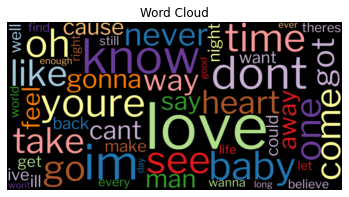

In [65]:
cher_tokens = lyrics_data.loc[lyrics_data['artist'] == 'cher']
word_freq = count_words(cher_tokens, column='tokens', min_freq=2)
wordcloud(word_freq['freq'], title='Word Cloud', max_words=50)
plt.show()

#### Word cloud for Robyn's lyrics

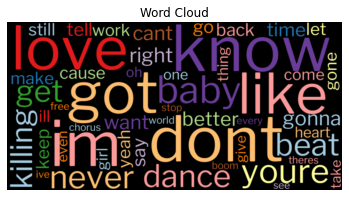

In [66]:
robyn_tokens = lyrics_data.loc[lyrics_data['artist'] == 'robyn']
word_freq = count_words(robyn_tokens, column='tokens', min_freq=2)
wordcloud(word_freq['freq'], title='Word Cloud', max_words=50)
plt.show()

#### Word cloud for Cher's twitter

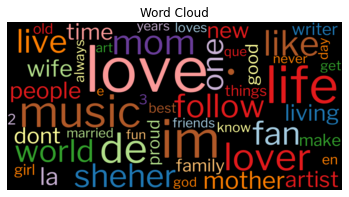

In [60]:
cher_tokens = twitter_data.loc[twitter_data['artist'] == 'cher'].dropna()
word_freq = count_words(cher_tokens, column='tokens', min_freq=2)
wordcloud(word_freq['freq'], title='Word Cloud', max_words=50)
plt.show()

#### Word cloud for Robyn's twitter

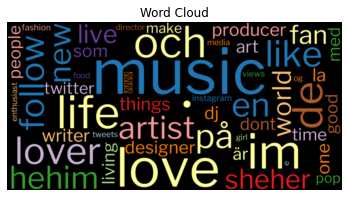

In [64]:
robyn_tokens = twitter_data.loc[twitter_data['artist'] == 'robyn'].dropna()
word_freq = count_words(robyn_tokens, column='tokens', min_freq=2)
wordcloud(word_freq['freq'], title='Word Cloud', max_words=50)
plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The word clouds generated from Cher's and Robyn's lyrics depict the prominent words and themes in their music, offering a glimpse into their respective artistic styles. Additionally, analyzing the word clouds from their follower Twitter accounts reveals distinct prominent words that reflect the unique interests and discussions within each artist's fan community.